In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv, det
from scipy.optimize import minimize

In [2]:
class RBFKernel:
    def __init__(self, signal_variance = 2, length_scale = 2) -> None:
        self.signal_variance = signal_variance
        self.length_scale = length_scale

    def transform(self, x1, x2):
        return self.signal_variance**2 * np.exp(-((x1-x2)**2)/2*self.length_scale**2)
    
    def set_params(self, signal_variance, length_scale):
        self.signal_variance = signal_variance
        self.length_scale = length_scale
        return self

In [3]:
def mean(X):
    # We assume 0 mean
    return np.zeros(shape=len(X))

def covariance(X1, X2, kernel):
    cov = np.zeros(shape=(len(X1), len(X2)))

    for i in range(len(X1)):
        for j in range(len(X2)):
            cov[i][j] = kernel.transform(X1[i], X2[j])
            
    return cov


In [7]:
n_train = 50
# n_test = 20

X_train = sorted(np.random.uniform(low=-5, high=5, size=n_train))
y_train = np.sin(X_train)

y_train = np.random.normal(0, 0.3, size=len(y_train)) + np.sin(X_train)
X_test = np.linspace(start=-6, stop=6, num=100)

In [5]:
class GP:
    def __init__(self, kernel) -> None:
        self.kernel = kernel
        pass
    
    def train(self, X_train, y_train, X_test):
        noise_variance = 0.1
        
        
        def nll(theta):
            kern = RBFKernel(theta[0], theta[1])
            noise_var = theta[2]
            cov_X_X = covariance(X_train, X_train, kern)
            noise_cov = noise_var*np.identity(n=len(cov_X_X))
            # cov_Xt_X = covariance(X_test, X_train, kern)
            # cov_Xt_Xt = covariance(X_test, X_test, kern)
            k_inv = inv(cov_X_X + noise_cov)

            # args(K + noise_cov, Y_train, k_inv, X_train)
            return 0.5 * np.log(det(cov_X_X+noise_cov)) + \
                   0.5 * (y_train - mean(X_train)).T @ k_inv @ (y_train-mean(X_train)) + \
                    0.5 * len(X_train) * np.log(2*np.pi)

        res = minimize(nll, [1, 1, 0.1],
               bounds=((1e-5, None), (1e-5, None), (1e-5, None)),
               method='L-BFGS-B')
        
        sv, ls, nv = res.x


        self.kernel = RBFKernel(sv, ls)
        cov_X_X = covariance(X_train, X_train, self.kernel)
        cov_Xt_X = covariance(X_test, X_train, self.kernel)
        cov_Xt_Xt = covariance(X_test, X_test, self.kernel)
        k_inv = inv(cov_X_X + nv*np.identity(n=len(cov_X_X)))
        
        mu =  mean(X_test) + cov_Xt_X @ k_inv @ (y_train-mean(X_train))
        sigma = cov_Xt_Xt - cov_Xt_X @ k_inv @ cov_Xt_X.T
        
        print(np.linalg.cond(cov_X_X+ noise_variance*np.identity(n=len(cov_X_X))))
        return mu, sigma, sv, ls, nv#, best_signal_variance, best_length_scale, best_noise_variance
    

    def prob(self, y_train, mean_x, noise_cov):
        y = multivariate_normal.rvs(mean=mean_x, cov=noise_cov)
        jitter = np.eye(len(noise_cov)) * 1e-6
        prob = multivariate_normal.pdf(y_train, mean=mean_x, cov=noise_cov + jitter)
        return prob

mod = GP(RBFKernel())
mu, sigma, sv, ls, nv = mod.train(X_train, y_train, X_test)
sv, ls, nv
# mu, sigma, best_signal_variance, best_length_scale, best_noise_variance = mod.train(X_train, y_train, X_test)
# best_signal_variance, best_length_scale, best_noise_variance


165.81411236148222


(0.9474835811437433, 0.6122525119201127, 0.08642787615596395)

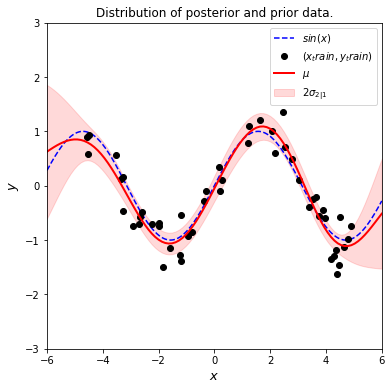

In [6]:
# Plot the postior distribution and some samples
fig, ax1 = plt.subplots(
    nrows = 1, ncols=1, figsize=(6, 6))

# Plot the correct distribution
x_space = np.linspace(start=-6, stop=6, num=1000)
y_space = np.sin(x_space)
ax1.plot(x_space, y_space, 'b--', label='$sin(x)$')
ax1.plot(X_train, y_train, 'ko', linewidth=2, label='$(x_train, y_train)$')

# Plot the posterior
ax1.plot(X_test, mu, 'r-', lw=2, label='$\mu$')
ax1.fill_between(X_test, mu-2*np.sqrt(np.diag(sigma)), mu+2*np.sqrt(np.diag(sigma)), color='red', alpha=0.15, label='$2 \sigma_{2|1}$')


ax1.set_xlabel('$x$', fontsize=13)
ax1.set_ylabel('$y$', fontsize=13)
ax1.set_title('Distribution of posterior and prior data.')
ax1.axis([-6, 6, -3, 3])
ax1.legend()

Observation: Too many training points will mess up the graph. Low noise messes up graph.

When length scale increases, or we have very dense points (lots of points in a small space), the kernel covariance flattens out. It becames a matrix of all ones. \
When you have a matrix of all 1's, you get a rank 1 matrix, because there is only 1 linearly independent row. This causes there to be only 1 non-zero eigenvalue. So the last eigenvalue is 0, and the condition number will be infnity. \
We want low condition number \
full rank means there are n eigenvalues and will allow the condition number to be low.\
 

use automatic gradient software to find parameters

matrix differential calculus

### GPFA

https://colab.research.google.com/drive/1LBT_kdN_CX99jyhZnKlX9yczkwh8LZF8?usp=sharing#scrollTo=rPF0DgQ9v3dJ